# Import modules

In [34]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode, chi2_contingency
from colorama import Fore
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize seaborn
sns.set(style="whitegrid")

# Global random seed
global global_seed

global_seed = 55

# Set random generator seeds

# Numpy
np.random.seed(global_seed)


# Load data

In [2]:
raw_data = pd.read_csv("dataset_SCL.csv", low_memory=False)
display(raw_data)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


# Inspect data

Inspect type of data on each column

In [3]:
# Get dtypes and NaN count
raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


From above, we can se <b>"Vlo-O"</b> column is the only one with a Null (NaN) value. If it were a numeric column, an interpolation (linear or mean replaced value) might be applied on to not lose any data, but in this case the best is to avoid using that row.</br></br>
<b>"Fecha-I"</b> and <b>"Fecha-O"</b> are objects/strings. Thus, we convert those date to datetime format, backing up raw_data for any future use.

In [4]:
# Copy raw_data and let it as backup
new_data = raw_data.copy()
# Convert time data to datetime
time_cols = ["Fecha-I", "Fecha-O"]
for col in time_cols:
    try:
        new_data[col] = pd.to_datetime(raw_data[col])
    except:
        pass
# Drop NaN rows
new_data.dropna(inplace=True)
# Get new dtypes
new_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68205 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68205 non-null  datetime64[ns]
 1   Vlo-I      68205 non-null  object        
 2   Ori-I      68205 non-null  object        
 3   Des-I      68205 non-null  object        
 4   Emp-I      68205 non-null  object        
 5   Fecha-O    68205 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68205 non-null  object        
 8   Des-O      68205 non-null  object        
 9   Emp-O      68205 non-null  object        
 10  DIA        68205 non-null  int64         
 11  MES        68205 non-null  int64         
 12  AÑO        68205 non-null  int64         
 13  DIANOM     68205 non-null  object        
 14  TIPOVUELO  68205 non-null  object        
 15  OPERA      68205 non-null  object        
 16  SIGLAORI   68205 non-null  object       

Then we can get some basic statistical analysis on columns by analizing the mode of each column and their unique values (due to being categorical data on mayority).

In [5]:
# Get second mode
scnd_mode = {}
scnd_mode_freq = {}
for col in new_data.columns:
    try:
        m = new_data[col].value_counts().index[1]
        f = new_data[col].value_counts().iloc[1]
    except IndexError:
        m = new_data[col].value_counts().index[0]
        f = new_data[col].value_counts().iloc[0]
    scnd_mode[col] = m
    scnd_mode_freq[col] = f
# Modes and their frequency, and, number of unique values of each column
pd.concat(
    [
        pd.DataFrame(mode(new_data)[0][0], columns=["Mode"], index=new_data.columns),
        pd.DataFrame(
            mode(new_data)[1][0], columns=["Frequency"], index=new_data.columns
        ),
        pd.DataFrame(scnd_mode, columns=scnd_mode.keys(), index=[0]).T.rename(
            columns={0: "Second_Mode"}
        ),
        pd.DataFrame(scnd_mode_freq, columns=scnd_mode_freq.keys(), index=[0]).T.rename(
            columns={0: "Second_Mode_Frequency"}
        ),
        new_data.nunique().rename("Unique"),
        new_data.count().rename("Count"),
    ],
    axis=1,
)



,Mode,Frequency,Second_Mode,Second_Mode_Frequency,Unique,Count
Fecha-I,2017-03-19 18:00:00,6,2017-03-19 18:00:00,6,53252,68205
Vlo-I,174,686,11,645,584,68205
Ori-I,SCEL,68205,SCEL,68205,1,68205
Des-I,SCFA,5787,SPJC,5269,64,68205
Emp-I,LAN,37611,SKU,14298,30,68205
Fecha-O,2017-05-19 07:01:00,5,2017-11-05 14:51:00,5,62774,68205
Vlo-O,174,649,11,646,861,68205
Ori-O,SCEL,68205,SCEL,68205,1,68205
Des-O,SCFA,5786,SPJC,5269,63,68205
Emp-O,LAN,20988,LXP,14558,32,68205


# Questions

### Data distribution

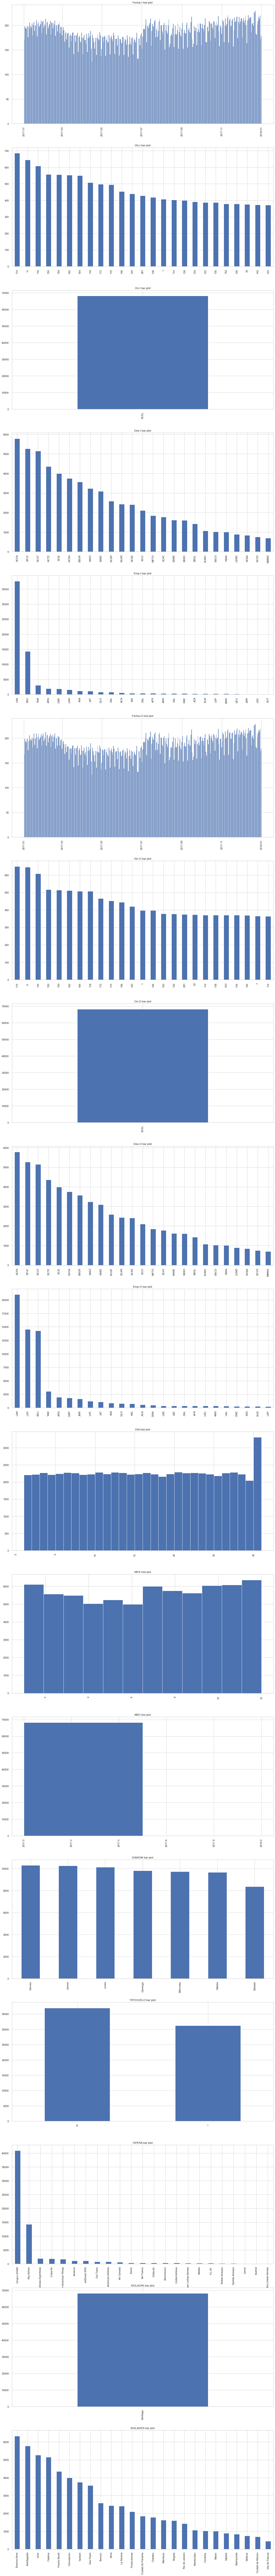

In [6]:
# Define list of plot type per column
plot_type_bycol = {
    "Fecha-I": ("hist", 365),
    "Vlo-I": ("bar", 0),
    "Ori-I": ("bar", 0),
    "Des-I": ("bar", 0),
    "Emp-I": ("bar", 0),
    "Fecha-O": ("hist", 365),
    "Vlo-O": ("bar", 0),
    "Ori-O": ("bar", 0),
    "Des-O": ("bar", 0),
    "Emp-O": ("bar", 0),
    "DIA": ("hist", 30),
    "MES": ("hist", 12),
    "AÑO": ("hist", 2),
    "DIANOM": ("bar", 0),
    "TIPOVUELO": ("bar", 0),
    "OPERA": ("bar", 0),
    "SIGLAORI": ("bar", 0),
    "SIGLADES": ("bar", 0),
}

# Create plots by type
fig, ax = plt.subplots(len(plot_type_bycol.items()), 1, figsize=(20, 200))
for ind, (col, p_type) in enumerate(plot_type_bycol.items()):
    try:
        ax[ind].set_title(f"{col} {p_type[0]} plot")
        if p_type[0].lower() == "bar":
            if new_data[col].nunique() >= 25:
                new_data[col].value_counts().iloc[:25].plot.bar(ax=ax[ind], rot=90)
            else:
                new_data[col].value_counts().plot.bar(ax=ax[ind], rot=90)
        elif p_type[0].lower() == "hist":
            new_data[col].hist(
                ax=ax[ind], xrot=90, bins=p_type[1]
            )  # For date, periodic drop (maybe Sunday(?))
        elif p_type[0].lower() == "box":
            new_data.boxplot(column=col, ax=ax[ind])
        else:
            print(f"Error - {col}")
    except:
        pass


From plots above we can extract certain insights:

<li>In the <b>Fecha-I</b> and <b>Fecha-O</b> plot, if we choose a binning near the width of 1 day, we can see certain patterns on peaks and lows. We can observe 4 lows in a time of 1 month (but without any further argument than seeing them with the naked eye) that might be <b>Sundays</b> or some day where people dont travel much.</li>
<li>We can see a seasonality on data from <b>january to july</b> and then from <b>july to january</b>, due to holydays probably.</li>
<li>We can't see any significant information by observing just the flight number (<b>Vlo-O</b> and <b>Vlo-I</b>), but we can see that most of the travels were done by flight number <b>174</b>.</li>
<li>We can see that the origin city (<b>Ori-I</b> and <b>Ori-O</b> and <b>SIGLAORI</b>) for all flights was <b>Santiago</b>.</li>
<li>We cant see any significant information by observing just the destiny city (<b>Des-I</b> and <b>Des-O</b>), but we can see that the most visited city is <b>SCFA</b>.</li>
<li>We can't see any significant information by observing just the airline company code (<b>Emp-I</b> and <b>Emp-O</b>), but we can see that most of the flights come from <b>LAN</b>.</li>
<li>We can see a <b>uniform distribution</b> of flights per day of the month (<b>MES</b>) at least at the early and mid terms, <b>increasing</b> at the final days of the month (this with a binning near to number of days), maybe due to salary payment period.</li>
<li>We can see a low on flight by <b>june/july</b> and two peaks near <b>july/august and december/january</b>.</li>
<li>We can't see any significant information by observing just the <b>DIANOM</b> column, but we can see <b>Fryday</b> is the day when most people fly.</li>
<li>We can't see any significant information by observing just the type of flight (<b>TIPOVUELO</b>), but we can see the most common type is <b>National</b> flights</li>
<li>We can't see any significant information by observing just the airline name (<b>OPERA</b>), but we can see the most flights come from <b>LATAM group</b></li>
<li>We can't see any significant information by observing just <b>SIGLADES</b>, but we can see the most visited city is <b>Buenos Aires</b></li>

### Aditional data

In [7]:
## Create columns

# Difference of operation an schedules dates in minutes
dif_min = [x.total_seconds() / 60 for x in (new_data["Fecha-O"] - new_data["Fecha-I"])]

# High demand season
date_ranges = [("03/03", "15/07"), ("31/07", "11/09"), ("30/09", "15/12")]
temporada_alta = [
    0
    if any(
        [
            (
                dt.datetime.strptime(y[0], "%d/%m").date().replace(year=2022)
                < x.date().replace(year=2022)
                and x.date().replace(year=2022)
                < dt.datetime.strptime(y[1], "%d/%m").date().replace(year=2022)
            )
            for y in date_ranges
        ]
    )
    else 1
    for x in new_data["Fecha-I"]
]  # Inclusive

# Delay of 15 minutes
atraso_15 = [1 if x > 15 else 0 for x in dif_min]
tp = {"mañana": (5, 12), "tarde": (12, 19), "noche": (19, 5)}
tp_d = {
    p: (
        dt.timedelta(hours=t[0]).total_seconds() / 3600,
        dt.timedelta(hours=t[1]).total_seconds() / 3600,
    )
    for p, t in tp.items()
}
new_data_Fecha_I_minutes = [x.hour for x in new_data["Fecha-I"]]

# Period of day
periodo_dia = [
    "mañana"
    if (x >= tp_d["mañana"][0] and x < tp_d["mañana"][1])
    else "tarde"
    if (x >= tp_d["tarde"][0] and x < tp_d["tarde"][1])
    else "noche"
    for x in new_data_Fecha_I_minutes
]



In [8]:
## Add columns
new_data = new_data.assign(
    dif_min=dif_min,
    temporada_alta=temporada_alta,
    atraso_15=atraso_15,
    periodo_dia=periodo_dia,
)



In [9]:
## Export to file
new_data[["dif_min", "temporada_alta", "atraso_15", "periodo_dia"]].to_csv(
    "synthetic_features.csv"
)



### Correlations

##### Correlation between delay and each other variables

In [10]:
# Create new column from dif_min (1 if delayed and -1 if advanced)
new_data = new_data.assign(
    dif_min_binary=new_data["dif_min"].apply(lambda x: 1 if x > 0 else 0)
)
# Get combinations of columns
cols_of_interest = [
    "dif_min_binary",
    "temporada_alta",
    "periodo_dia",
    "MES",
    "DIANOM",
    "TIPOVUELO",
    "OPERA",
    "SIGLADES",
]
# Get number of combinations with dif_min_binary
col_pairs = [
    col_pair
    for col_pair in itertools.combinations(cols_of_interest, 2)
    if "dif_min_binary" in col_pair
]
# Create contingency table for each combination
chi2 = {}
pvals = {}
for ind, col_pair in enumerate(col_pairs):
    try:
        # Get cross table
        cross_tab = pd.crosstab(new_data[col_pair[0]], new_data[col_pair[1]])
        display(cross_tab)
        print(f"{Fore.MAGENTA}{col_pair}{Fore.WHITE}")
        # Drop low frequencies
        cols = [
            col
            for col in cross_tab.columns
            if any([cross_tab[col][ind] <= 5 for ind in cross_tab.index])
        ]
        print(
            f"{Fore.CYAN}Dropped columns (due to low frequencies){Fore.WHITE} : {cols}"
        )
        cross_tab = cross_tab.drop(columns=cols)
        # Hypothesis testing (with dropped columns)
        chi2_test = chi2_contingency(cross_tab)
        print(f"{Fore.CYAN}Chi-square value{Fore.WHITE} : {chi2_test[0]}")
        print(f"{Fore.CYAN}P-value (with dropped columns){Fore.WHITE} = {chi2_test[1]}")
        cond_reject = chi2_test[1] <= 0.05
        print(
            f"{Fore.CYAN}H0 rejected (correlated columns){Fore.WHITE} = {Fore.GREEN if cond_reject else Fore.RED}{cond_reject}"
        )
        chi2[[x for x in col_pair if "dif_min_binary" != x][0]] = chi2_test[0]
        pvals[[x for x in col_pair if "dif_min_binary" != x][0]] = chi2_test[1]
    except ValueError:
        pass


temporada_alta,0,1
dif_min_binary,,
0,15495,7204
1,29949,15557


('dif_min_binary', 'temporada_alta')
Dropped columns (due to low frequencies) : []
Chi-square value : 40.761448992508754
P-value (with dropped columns) = 1.7199281526177172e-10
H0 rejected (correlated columns) = True


periodo_dia,mañana,noche,tarde
dif_min_binary,,,
0,8617,6238,7844
1,16734,11110,17662


('dif_min_binary', 'periodo_dia')
Dropped columns (due to low frequencies) : []
Chi-square value : 135.11999891428655
P-value (with dropped columns) = 4.561052155098444e-30
H0 rejected (correlated columns) = True


MES,1,2,3,4,5,6,7,8,9,10,11,12
dif_min_binary,,,,,,,,,,,,
0,2066,1933,2381,2046,1880,1751,1378,2027,1989,1732,1870,1646
1,4041,3628,3101,2974,3360,3230,4614,3717,3621,4300,4210,4710


('dif_min_binary', 'MES')
Dropped columns (due to low frequencies) : []
Chi-square value : 948.8437607314331
P-value (with dropped columns) = 1.9463006383679675e-196
H0 rejected (correlated columns) = True


DIANOM,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes
dif_min_binary,,,,,,,
0,3534,3244,3291,3456,3306,2957,2911
1,6262,7006,6840,6206,6416,5395,7381


('dif_min_binary', 'DIANOM')
Dropped columns (due to low frequencies) : []
Chi-square value : 211.58575781362237
P-value (with dropped columns) = 6.468880636862522e-43
H0 rejected (correlated columns) = True


TIPOVUELO,I,N
dif_min_binary,,
0,10043,12656
1,21196,24310


('dif_min_binary', 'TIPOVUELO')
Dropped columns (due to low frequencies) : []
Chi-square value : 33.14752951365868
P-value (with dropped columns) = 8.542484154690932e-09
H0 rejected (correlated columns) = True


OPERA,Aerolineas Argentinas,Aeromexico,Air Canada,Air France,Alitalia,American Airlines,Austral,Avianca,British Airways,Copa Air,Delta Air,Gol Trans,Grupo LATAM,Iberia,JetSmart SPA,K.L.M.,Lacsa,Latin American Wings,Oceanair Linhas Aereas,Plus Ultra Lineas Aereas,Qantas Airways,Sky Airline,United Airlines
dif_min_binary,,,,,,,,,,,,,,,,,,,,,,,
0,797,273,127,207,109,542,26,492,81,1165,248,335,10760,149,448,164,52,420,145,7,17,5868,267
1,1152,78,438,151,150,215,48,660,124,685,110,471,30132,213,647,87,40,1253,134,42,178,8430,68


('dif_min_binary', 'OPERA')
Dropped columns (due to low frequencies) : []
Chi-square value : 3957.852124855704
P-value (with dropped columns) = 0.0
H0 rejected (correlated columns) = True


SIGLADES,Antofagasta,Arica,Asuncion,Atlanta,Auckland N.Z.,Balmaceda,Bariloche,Bogota,Buenos Aires,Calama,Cancun,Castro (Chiloe),Cataratas Iguacu,Ciudad de Mexico,Ciudad de Panama,Cochabamba,Concepcion,Copiapo,Cordoba,"Curitiba, Bra.",Dallas,Florianapolis,Guayaquil,Houston,Iquique,Isla de Pascua,La Paz,La Serena,Lima,Londres,Los Angeles,Madrid,Melbourne,Mendoza,Miami,Montevideo,Neuquen,Nueva York,Orlando,Osorno,Paris,"Pisco, Peru",Puerto Montt,Puerto Natales,Puerto Stanley,Punta Arenas,Punta Cana,Punta del Este,Quito,Rio de Janeiro,Roma,Rosario,"San Juan, Arg.",Santa Cruz,Sao Paulo,Sydney,Temuco,Toronto,Tucuman,Ushuia,Valdivia,Washington
dif_min_binary,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2269,877,43,248,54,211,0,558,1780,2157,14,95,1,384,1165,0,1507,636,149,2,273,47,131,266,1112,76,46,915,1582,81,27,276,3,361,392,219,13,81,9,74,207,0,1175,33,0,429,6,3,0,317,109,11,9,12,1039,17,795,94,13,0,295,1
1,3517,1559,189,110,307,628,2,1046,4555,2989,49,140,1,316,685,1,2486,1144,874,1,84,115,291,68,2635,376,163,1495,3687,124,128,618,36,1264,624,847,24,301,25,185,152,1,3182,46,1,1676,48,3,2,1118,150,125,26,108,2530,177,1794,189,25,6,458,0


('dif_min_binary', 'SIGLADES')
Dropped columns (due to low frequencies) : ['Bariloche', 'Cataratas Iguacu', 'Cochabamba', 'Curitiba, Bra.', 'Melbourne', 'Pisco, Peru', 'Puerto Stanley', 'Punta del Este', 'Quito', 'Ushuia', 'Washington']
Chi-square value : 3354.842786849323
P-value (with dropped columns) = 0.0
H0 rejected (correlated columns) = True


##### Ratio plots (with dropped columns)

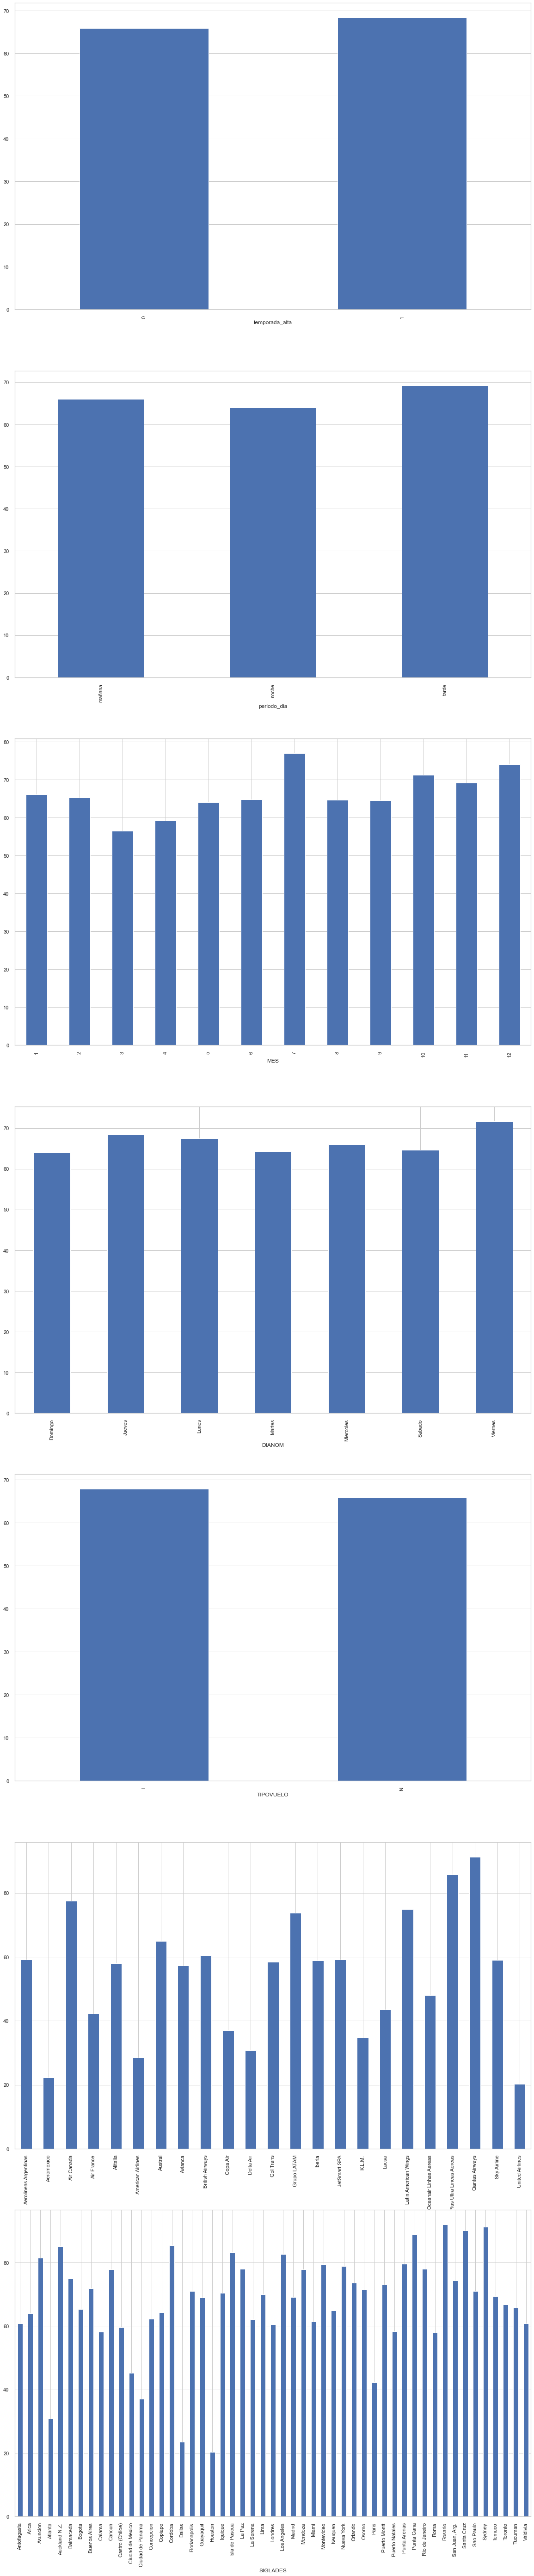

In [11]:
# Get number of combinations with dif_min_binary
col_pairs = [
    col_pair
    for col_pair in itertools.combinations(cols_of_interest, 2)
    if "dif_min_binary" in col_pair
]
# Create contingency table for each combination
fig, ax = plt.subplots(len(col_pairs), 1, figsize=(20, 100))
for ind, col_pair in enumerate(col_pairs):
    try:
        # Get cross table
        cross_tab = pd.crosstab(new_data[col_pair[0]], new_data[col_pair[1]])
        # Drop low frequencies
        cols = [
            col
            for col in cross_tab.columns
            if any([cross_tab[col][ind] <= 5 for ind in cross_tab.index])
        ]
        cross_tab = cross_tab.drop(columns=cols)
        # Plot ratio of each combination
        (cross_tab.iloc[1] / cross_tab.sum(axis=0) * 100).plot.bar(ax=ax[ind], rot=90)
    except ValueError:
        pass


##### Correlation between delay and other variables, all at once

In [12]:
# Create contingency table for each combination
dif_cols_of_interest = [
    "temporada_alta",
    "periodo_dia",
    "MES",
    "DIANOM",
    "TIPOVUELO",
    "OPERA",
    "SIGLADES",
]
cont_tab = pd.crosstab(
    new_data["dif_min_binary"], [new_data[col] for col in dif_cols_of_interest]
)
display(cont_tab)


temporada_alta                     0                                     \
periodo_dia                   mañana                                      
MES                               3                                       
DIANOM                       Domingo                                      
TIPOVUELO                          I                                      
OPERA          Aerolineas Argentinas   Air Canada Alitalia Avianca        
SIGLADES                Buenos Aires Buenos Aires     Roma  Bogota Lima   
dif_min_binary                                                            
0                                  2            0        0       3    3   
1                                  5            1        1       1    0   

temporada_alta                                                              \
periodo_dia                                                                  
MES                                                                          
DIANOM                                                                       
TIPOVUELO                                                                    
OPERA                  Copa Air Gol Trans Grupo LATAM                        
SIGLADES       Ciudad de Panama Sao Paulo      Bogota Buenos Aires Cordoba   
dif_min_binary                                                               
0                             3         3           2            2       2   
1                             0         1           2           14       2   

temporada_alta                                                         \
periodo_dia                                                             
MES                                                                     
DIANOM                                                                  
TIPOVUELO                                                               
OPERA                                                                   
SIGLADES       Florianapolis Guayaquil La Paz Lima Mendoza Montevideo   
dif_min_binary                                                          
0                          1         0      2    6       1          3   
1                          0         3      0    6       7          1   

temporada_alta                                                           \
periodo_dia                                                               
MES                                                                       
DIANOM                                                                    
TIPOVUELO                                                                 
OPERA                                              Latin American Wings   
SIGLADES       Punta Cana Rio de Janeiro Sao Paulo                 Lima   
dif_min_binary                                                            
0                       1              0         5                    1   
1                       3              4        10                    2   

temporada_alta                                                           \
periodo_dia                                                               
MES                                                                       
DIANOM                                                                    
TIPOVUELO                                             N                   
OPERA           Sky Airline                 Grupo LATAM                   
SIGLADES       Buenos Aires Lima Montevideo Antofagasta Arica Balmaceda   
dif_min_binary                                                            
0                         3    2          0           1     2         2   
1                         1    2          1           3     2         2   

temporada_alta                                                    \
periodo_dia                                                        
MES                                                                
DIANOM                         

In [13]:
# Get maxmimum frequency value and associated column
ind_max = cont_tab.iloc[1].argmax()
ind_max_col = cont_tab.columns[ind_max]
print(f"{Fore.CYAN}Highest frequency combination{Fore.WHITE} = {ind_max_col}")
# Show p-values
print(f"{Fore.CYAN}P-values{Fore.WHITE} : {pvals}")


Highest frequency combination = (1, 'noche', 1, 'Lunes', 'I', 'Grupo LATAM', 'Lima')
P-values : {'temporada_alta': 1.7199281526177172e-10, 'periodo_dia': 4.561052155098444e-30, 'MES': 1.9463006383679675e-196, 'DIANOM': 6.468880636862522e-43, 'TIPOVUELO': 8.542484154690932e-09, 'OPERA': 0.0, 'SIGLADES': 0.0}


In [14]:
# Get number of combinations with dif_min_binary
col_pairs = [
    col_pair
    for col_pair in itertools.combinations(new_data.columns, 2)
    if "dif_min_binary" in col_pair
]
# Create contingency table for each combination
chi2 = {}
pvals = {}
for ind, col_pair in enumerate(col_pairs):
    try:
        # Get cross table
        cross_tab = pd.crosstab(new_data[col_pair[0]], new_data[col_pair[1]])
        # Drop low frequencies
        cols = [
            col
            for col in cross_tab.columns
            if any([cross_tab[col][ind] <= 5 for ind in cross_tab.index])
        ]
        cross_tab = cross_tab.drop(columns=cols)
        # Hypothesis testing (with dropped columns)
        chi2_test = chi2_contingency(cross_tab)
        cond_reject = chi2_test[1] <= 0.05
        if cond_reject:
            print(f"{Fore.MAGENTA}{col_pair}{Fore.WHITE}")
            print(f"{Fore.CYAN}Chi-square value{Fore.WHITE} = {chi2_test[0]}")
            print(
                f"{Fore.CYAN}P-value (with dropped columns){Fore.WHITE} = {chi2_test[1]}"
            )
            print(
                f"{Fore.CYAN}H0 rejected (correlated columns){Fore.WHITE} = {Fore.GREEN if cond_reject else Fore.RED}{cond_reject}{Fore.WHITE}"
            )
    except ValueError:
        pass


('DIA', 'dif_min_binary')
Chi-square value = 107.00936930678162
P-value (with dropped columns) = 1.4073097117408072e-10
H0 rejected (correlated columns) = True
('MES', 'dif_min_binary')
Chi-square value = 948.8437607314333
P-value (with dropped columns) = 1.946300638367746e-196
H0 rejected (correlated columns) = True
('DIANOM', 'dif_min_binary')
Chi-square value = 211.58575781362237
P-value (with dropped columns) = 6.468880636862522e-43
H0 rejected (correlated columns) = True
('TIPOVUELO', 'dif_min_binary')
Chi-square value = 33.14752951365868
P-value (with dropped columns) = 8.542484154690932e-09
H0 rejected (correlated columns) = True
('OPERA', 'dif_min_binary')
Chi-square value = 3957.8521248557036
P-value (with dropped columns) = 0.0
H0 rejected (correlated columns) = True
('temporada_alta', 'dif_min_binary')
Chi-square value = 40.761448992508754
P-value (with dropped columns) = 1.7199281526177172e-10
H0 rejected (correlated columns) = True
('periodo_dia', 'dif_min_binary')
Chi-squ

After analyzing the different p-values and ratio of delay on flights, we can see:
<li>There are odd p-values (too small and the highest) for airline operator and destination city, with relation with flight delay, and a very high statistic value, which might be a sign of extremely correlated features (target-feature) or an statistical error/outlier. Anyway, a flight delay may be related with the destination city due to infraestructure, concurrency, etc; and it can be related with the operator airline due to bad management, high demand and low offer, etc.</li>
<li>The features with the highest (non-zero) p-value and statistic value, rejecting H0, are month and day of the week, which were noticed on the distribution analysis, where appeared periodic lows inside each month (maybe weeks) and, due to high and low demand seasons, certain months were more inclined to have delays.</li>
<li>In spite of month being the lowest (non-zero) p-value, the common sense tell us high demand season should be comparable, but the order of difference is too big.</li>
<li>In conclusion, the features that should have the most impact on flight delay would be: <b><i>destination, operator airline, month, day of the week, period of the day, high demand and flight type</i></b> on decreasing order.</li>

### Modeling data

##### Label selection

We select <b>dif_min</b> as label/target, but with certain considerations:

<li>For a classification problem, where we try to predict if a flight is just delayed or not, we can use a binary feature from it, so we create <b>dif_min_binary</b>.</li>
<li>For a classification problem, where we try to predict if a flight is delayed more than 15 minutes or less than it, we can use <b>atraso_15</b>, but we will choose the above, to just predict if the flight is delayed or not.</li>

In [15]:
label = "dif_min_binary"

##### Feature selection

<li>We avoid using the <b>Fecha-I</b>, <b>Fecha-O</b> and <b>dif_min</b> columns, as they are the source for creation of the label/target column (highly correlated, even more, pseudo-collinearity).</li>
<li>Equally, we avoid using the <b>atraso-15</b> feature as is created from <b>dif_min</b> column (highly correlated, even more, pseudo-collinearity).</li>
<li>We avoid using <b>Vuelo-I</b> and <b>Vuelo-O</b> because we dont have any information at priori, apart from the flight number. If we can relate it with the airplane model, or anything else, it could give us some information, but in this case it just gives more categorical features with no guaranteed impact (increased execution time).</li>

In [16]:
# Avoid high correlated features
data_model = new_data.drop(
    columns=["dif_min", "Fecha-O", "Fecha-I", "Vlo-O", "Vlo-I", "atraso_15"]
)
print(data_model.columns)


Index(['Ori-I', 'Des-I', 'Emp-I', 'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES',
       'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES',
       'temporada_alta', 'periodo_dia', 'dif_min_binary'],
      dtype='object')


##### Model training

We will use the pycaret module to train and compare different models.

By default, it implements routines to split dataset into train and validations sub datasets and to convert categorical features into binary ones (One Hot Encoding).

In [17]:
# Function for experiment (models comparison)
def make_experiment(label, data, models_included, k_fold=10, exp_name="experiment"):
    """
    Make experiment for each model.
    """

    ## Create comparison between models

    # Initialize experiment
    class_experiment = setup(
        data,
        target=label,
        session_id=global_seed,  # Random seed
        log_experiment=False,
        experiment_name=exp_name,
        use_gpu=True,
    )
    # Compare models
    best_model = compare_models(include=models_included, fold=k_fold)

    return best_model


We choose a certain number of models to train and compare.

Mainly, we use some tree based models for classification, due to the nature of the problem.

The different type of features are certainly jerarquical, going from destination and airline to the days of the week and period of the day.

We can see for example, solely based on logic, that the delay might be determined by the destination, then the airline, then the month, day, day of the week and period of day, in that order by level of impact).

In [18]:
# Define models that will be included in comparison
models_included = [
    "lr",
    "gbc",
    "rf",
    "dt",
    "svm",
]



We then split data for train and test purposes.

In [19]:
# Split data into train and test
X, y = data_model[data_model.columns.difference([label])], data_model[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state=global_seed)  # Low test size because we will choose a low number data for modelling
# Create dataframes
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

print('Train data')
display(data_train)
print('Test data')
display(data_test)

Train data


,AÑO,DIA,DIANOM,Des-I,Des-O,Emp-I,Emp-O,MES,OPERA,Ori-I,Ori-O,SIGLADES,SIGLAORI,TIPOVUELO,periodo_dia,temporada_alta,dif_min_binary
51787,2017,19,Jueves,SCAR,SCAR,SKU,SKU,10,Sky Airline,SCEL,SCEL,Arica,Santiago,N,mañana,0,0
63671,2017,19,Martes,SCCF,SCCF,SKU,SKU,12,Sky Airline,SCEL,SCEL,Calama,Santiago,N,mañana,1,1
54139,2017,9,Lunes,SABE,SABE,LAN,LAN,10,Grupo LATAM,SCEL,SCEL,Buenos Aires,Santiago,I,mañana,0,1
32831,2017,24,Lunes,SKBO,SKBO,AVA,AVA,7,Avianca,SCEL,SCEL,Bogota,Santiago,I,noche,1,0
2066,2017,6,Viernes,SCDA,SCDA,SKU,SKU,1,Sky Airline,SCEL,SCEL,Iquique,Santiago,N,mañana,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38257,2017,19,Miercoles,SPJC,SPJC,LAW,JMR,7,Latin American Wings,SCEL,SCEL,Lima,Santiago,I,noche,1,0
10214,2017,28,Martes,SCCF,SCCF,LAN,LXP,2,Grupo LATAM,SCEL,SCEL,Calama,Santiago,N,mañana,1,1
16254,2017,23,Jueves,SKBO,SKBO,LAN,LAN,3,Grupo LATAM,SCEL,SCEL,Bogota,Santiago,I,tarde,0,1
28968,2017,10,Sabado,SCCF,SCCF,SKU,SKU,6,Sky Airline,SCEL,SCEL,Calama,Santiago,N,tarde,0,1


Test data


,AÑO,DIA,DIANOM,Des-I,Des-O,Emp-I,Emp-O,MES,OPERA,Ori-I,Ori-O,SIGLADES,SIGLAORI,TIPOVUELO,periodo_dia,temporada_alta,dif_min_binary
20764,2017,24,Lunes,SCCF,SCCF,LAN,LXP,4,Grupo LATAM,SCEL,SCEL,Calama,Santiago,N,mañana,0,0
27921,2017,5,Lunes,MPTO,MPTO,CMP,CMP,6,Copa Air,SCEL,SCEL,Ciudad de Panama,Santiago,I,noche,0,0
2150,2017,6,Viernes,SCDA,SCDA,SKU,SKU,1,Sky Airline,SCEL,SCEL,Iquique,Santiago,N,noche,1,0
58141,2017,13,Lunes,SCFA,SCFA,LAN,LAN,11,Grupo LATAM,SCEL,SCEL,Antofagasta,Santiago,N,mañana,0,0
53785,2017,13,Viernes,SCCF,SCCF,LAN,LXP,10,Grupo LATAM,SCEL,SCEL,Calama,Santiago,N,mañana,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62070,2017,24,Domingo,SABE,SABE,ARG,ARG,12,Aerolineas Argentinas,SCEL,SCEL,Buenos Aires,Santiago,I,mañana,1,1
26590,2017,7,Domingo,KJFK,KJFK,LAN,LAN,5,Grupo LATAM,SCEL,SCEL,Nueva York,Santiago,I,noche,0,1
17117,2017,15,Miercoles,SCIE,SCIE,JMR,JMR,3,Latin American Wings,SCEL,SCEL,Concepcion,Santiago,N,mañana,0,1
25410,2017,28,Domingo,SCTE,SCTE,LAN,LXP,5,Grupo LATAM,SCEL,SCEL,Puerto Montt,Santiago,N,noche,0,1


We, then, begin the training of the models on the experiment defined above, with <b>dif_min_binary</b> as label/target.

We select a random sample of data (to extract same distribution, we might use stratification) to reduce the computational time due to hardware capabilities and for testing only (EDA).

Note: Note that if running code with previously saved model, default matrix with scores wont be shown.

In [20]:
# Reduce number of data on train set
data = data_train.copy().sample(frac=0.1)  # 10%

# Find best model
try:
    best_model = load_model("best_model")
except FileNotFoundError:
    # Compare models and get best one
    best_model = make_experiment(
        label, data, models_included, exp_name="Flight delay experiment"
    )
    # Save experiment result to file
    save_model(best_model, "best_model")
# Print label used
print(f"Label used = {label}")
# Print best model
print(f"Best model = {best_model}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6875,0.6646,0.9559,0.6938,0.8040,0.1205,0.1717,0.5250
lr,Logistic Regression,0.6836,0.6693,0.9076,0.7052,0.7936,0.1587,0.1851,0.1550
rf,Random Forest Classifier,0.6701,0.6325,0.8372,0.7179,0.7729,0.1828,0.1903,0.8770
dt,Decision Tree Classifier,0.5835,0.5385,0.6705,0.6969,0.6831,0.0754,0.0756,0.0290
svm,SVM - Linear Kernel,0.5835,0.0000,0.6970,0.7212,0.6053,0.0551,0.0974,0.0800


Transformation Pipeline and Model Successfully Saved
Label used = dif_min_binary
Best model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=55, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


We found that <b>Gradient Boosting Classifier (GBC)</b> is the best model from the above list of models.

This modules uses a K-Fold cross validation to optimize the hyperparameters, so we can see the best selected ones and the mean scores on validation set.

As configuration, we use K=10 (validation_fraciton=0.1), so data set is divided on 10 parts, and the model is trained on 9 parts and tested on the last part (10 times).

To obtain a better explainablity on the model, we choose to train a Ranfom Forest (RF) classifier too and run some routines to explain it.

In [21]:
label = "dif_min_binary"
data = data_train.copy().sample(frac=0.1)

# Find best model
try:
    rf_best_model = load_model("rf_best_model")
except FileNotFoundError:
    # Compare models and get best one
    rf_best_model = make_experiment(
        label, data, ['rf'], exp_name="Flight delay experiment"
    )
    # Save experiment result to file
    save_model(rf_best_model, "rf_best_model")
# Print label used
print(f"Label used = {label}")
# Print best model
print(f"Best model = {rf_best_model}")


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6701,0.6325,0.8372,0.7179,0.7729,0.1828,0.1903,0.6690


Transformation Pipeline and Model Successfully Saved
Label used = dif_min_binary
Best model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)


Then, we optimize the hyperparameters for the best model found by the module (maximum number of highest scores on each performance metric/column).

We optimize by the F1-score to take into account the precision and recall scores at the same time, this way we can compare models where the precision is higher than the recall and the otherway too.

In [22]:
# Tune hyperparameters of best model
try:
    rf_tuned_best_model = load_model("rf_tuned_best_model")
except FileNotFoundError:
    # Hyperparameters optimization
    rf_tuned_best_model = tune_model(
        rf_best_model,
        n_iter=10,
        optimize="F1",
        search_library="optuna",
        choose_better=True,
    )
    # Save model to file
    save_model(rf_tuned_best_model, "rf_tuned_best_model")

# Print tuned best model
print(f"Tuned best model = {rf_tuned_best_model}")


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6784,0.6854,0.9836,0.6803,0.8043,0.0487,0.1050
1,0.6762,0.6340,0.9572,0.6847,0.7984,0.0803,0.1229
2,0.7004,0.7072,0.9770,0.6972,0.8137,0.1473,0.2287
3,0.6916,0.6462,0.9671,0.6934,0.8077,0.1260,0.1902
4,0.6960,0.6536,0.9770,0.6939,0.8115,0.1311,0.2098
5,0.6843,0.6660,0.9638,0.6894,0.8038,0.0983,0.1520
6,0.6909,0.6649,0.9671,0.6934,0.8077,0.1191,0.1816
7,0.6711,0.6648,0.9638,0.6798,0.7973,0.0481,0.0823
8,0.6645,0.6342,0.9539,0.6776,0.7923,0.0353,0.0571
9,0.6909,0.6611,0.9737,0.6916,0.8087,0.1114,0.1806


Transformation Pipeline and Model Successfully Saved
Tuned best model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=8,
                       max_features=0.5105271963561426, max_leaf_nodes=None,
                       max_samples=None,
                       min_impurity_decrease=0.00022644199686817662,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=181, n_jobs=-1, oob_score=False,
                       random_state=55, verbose=0, warm_start=False)


Finally, we evaluate the model to show results.

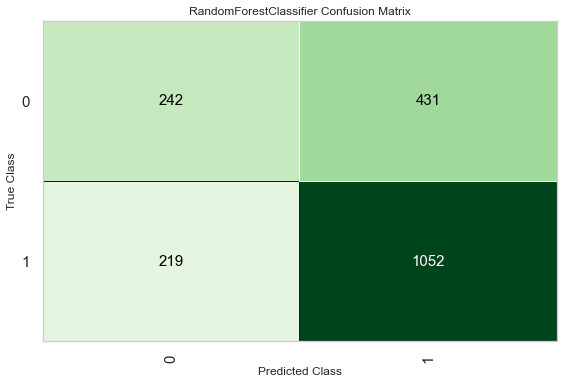

In [23]:
# Plot confussion matrix
plot_model(rf_best_model, plot = 'confusion_matrix')

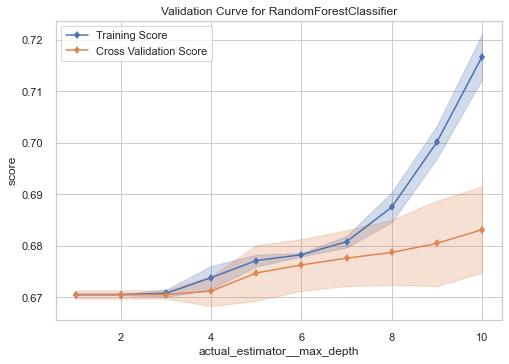

In [24]:
# Plot validation curve
plot_model(rf_best_model, plot='vc')

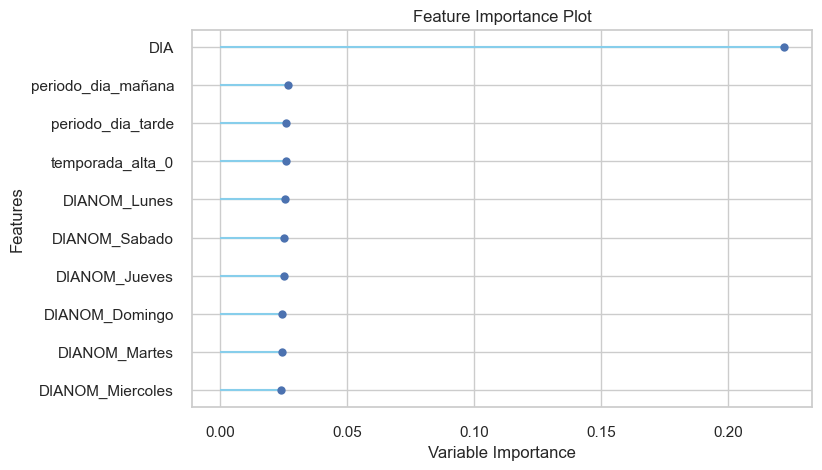

In [25]:
# Plot importance plot
plot_model(rf_best_model, plot='feature')

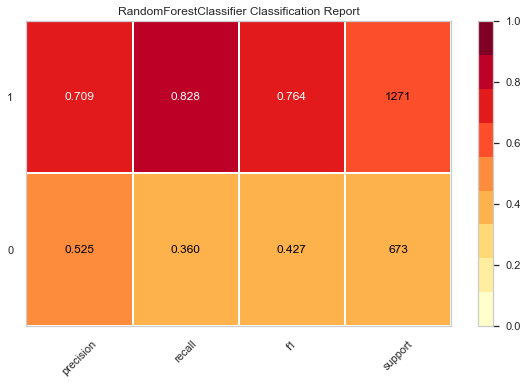

In [26]:
# Plot scores report
plot_model(rf_best_model, plot='class_report')

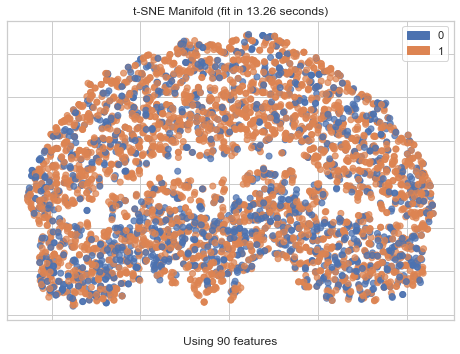

In [27]:
# Plot dimensionality reduction results
plot_model(rf_best_model, plot='manifold')

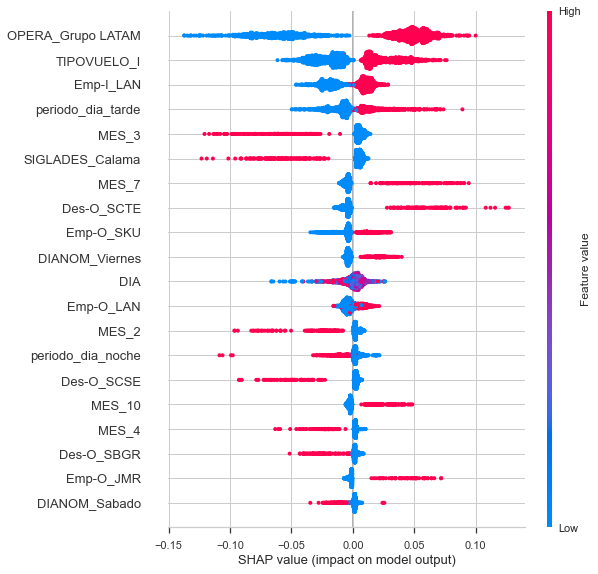

In [28]:
# Plot SHAP values summary plot
interpret_model(rf_tuned_best_model, plot="summary")

##### Predict on test data

 Mean of score on test set (%) = 67.767
 Standard deviation of score on test set = 10.026


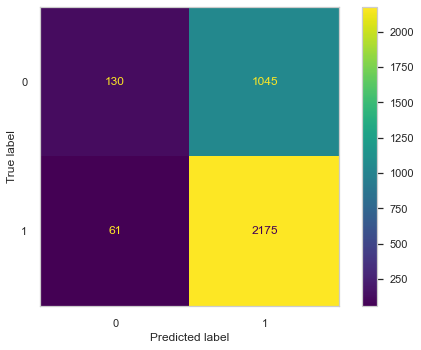

In [38]:
# Predict data
results_df = predict_model(rf_tuned_best_model, data_test)
# Show scores
m_score = results_df.Score.mean()
s_score = results_df.Score.std()
print(f"{Fore.CYAN} Mean of score on test set (%) = {Fore.GREEN if m_score >=0.75 else Fore.YELLOW if m_score <0.75 and m_score >= 0.5 else Fore.RED}{round(m_score*100, 3)}{Fore.WHITE}")
print(f"{Fore.CYAN} Standard deviation of score on test set = {Fore.MAGENTA}{round(s_score*100, 3)}{Fore.WHITE}")
# Plot confusion matrix
cm = confusion_matrix(results_df['dif_min_binary'], results_df['Label'], labels=results_df['dif_min_binary'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results_df['dif_min_binary'].unique())
disp.plot()
plt.grid(False)

##### Analysis

<li>We observe from the confussion matrix that there is a relatively low number of false positives and true negatives return by the model (~33% of errors and ~67% of correct results).</li>

<li>At first look, in the validation curve plot, we can see that with a higher number of estimators we could achieve a better performance on both training and validation. An expected result, due to the increasing on complexity of the forest (number of predictors).</li>

<li>From the importance plot, we see that the most important feature (from model results) is <b>DIA</b>, with a <i>4x</i> magnitude wich respect to the next most important feature and so on, being the following <b>periodo_dia</b>, <b>temporada_alta</b> and <b>DIANOM</b>, features expected to be meaningful to the classification results.</li>

<li>We see that, in the "delayed" class, the precision (true positives/total positives) and recall (true positives/total trues) scores are good too, leading to a good F1 score. In the "not delayed" class, we see a worse performance due, probably, to the almost half ammount of values on the class compared with the "delayed" one. This problem should be taken into account when constructing the label class (dropping some samples for the bigger class or adding more to the smaller).</li>

<li>We can see from the SHAP values summary plot, that the feature with most impact on the model output is by far the <b>Grupo Latam</b> airline operator, but we need to have into accound that most of the samples come from this airline, as noted in the bar plots at the beginning of the study, so this results could be biased.</li>

<li>We can see from the dimensionality reduction (t-SNE manifold) that data may behave non linearly and may have two distribution/sources of data, which can lead to bad results when trying to model all data together. Perhaps a PCA/t-SNE analysis and posterior clustering to select data groups, and then train the models would be a better approach to the problem.</li>

<li>Finally, we can observe that applying our model into unseen data (test data set) our model performs well with a F1-score of <i>0.67</i>. Analyzing the confusion matrix we can see a 68% of correct classification and a 32% of uncorrect classification, which is a very high score for an small train data set (~10% of raw data values).</li>

# Conclusion

We note, that from the results, the data must be treated accordingly to handle the problems found and to avoid bias. We should take into account a further data preprocessing step before modelling this data.

We can see too that our analysis before modelling, trying to predict which feature would be the most meaningful or impactful on the model, were close to the actual results. The features with higher impact where <b>DIA</b>, <b>periodo_dia</b>, <b>temporada_alta</b>, <b>DIANOM</b>, <b>MES</b>, <b>SIGLADES</b>, destination and airline operator/enterprise.

Is good to know that we can improve the performance by adding some changes:

<li>Increasing the general number of samples</li>
<li>Increasing the number of features, taking into account their correlation with the label (airplane model, specifications, velocity if we want to predict ETA, etc.).</li>
<li>Increasing the number of estimators when using tree-based models or the number of iterations/epochs when training neural networks or similar approaches.</li>
<li>Stratifying the data to obtain better train and test datasets, preserving the general distribution on each dataset.</li>
<li>Taking into account the number of class samples and the impact on model response that this could generate on the results.</li>